<a href="https://colab.research.google.com/github/jbpacker/time/blob/main/TensorTrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorTrade Example
This was adapted from here:
https://github.com/tensortrade-org/tensortrade/blob/master/examples/use_attentionnet_rllib.ipynb

## NOTES
(For what to do next time)


1. I'm pretty sure my price normalization is screwing something up. I need to dig into a better strategy here.
 * diff(log(X)) as input! when doing diff you lose an element in the array. need to figure out what to do there.
1. Try out relu or tanh between linear network layers
2. Add more features!! Right now it's just open price, and it'd be way better with more features. I just need to make sure that all features are normalized correctly. 
2. Once I have more features then I can explore different models
 * https://github.com/Ivsxk/RAT/blob/master/main.py
 * https://github.com/QData/spacetimeformer/blob/2c02b4bad86fa483d96f9ae978bf2bb8467af24e/spacetimeformer/spacetimeformer_model/spacetimeformer_model.py

2. I need to dive into the loss. I think using MSE of the prices is way too large!! I need to look at the sharpe ratio, or dive into papers to see what they do for loss.
 * Use the percent change as network output.

## Installation
Need to install
* TensorTrade
* torch
* pytorch-lightning
* weights and biases

In [ ]:
!pip install wandb
!pip install pytorch-lightning
!python3 -m pip install git+https://github.com/tensortrade-org/tensortrade.git

In [ ]:
import wandb
wandb.login(relogin=True)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Download Data
Use the TensorTrade CryptoDataDownload interface to download a pandas dataframe of features. It can be used to download any currency desired, and resamples with a zero order hold (copies prev value) if there's any data missing.

This is taken from https://github.com/tensortrade-org/tensortrade/blob/master/examples/use_attentionnet_rllib.ipynb

In [ ]:
from tensortrade.data.cdd import CryptoDataDownload

import datetime
import numpy as np
import pandas as pd
pd.options.mode.use_inf_as_na = True

def prepare_data(df):
    df['volume'] = np.int64(df['volume'])
    df['date'] = pd.to_datetime(df['date'])

    ### This is an attempt to add lines for missing times.
    df = df.drop_duplicates(subset='date')
    df = df.set_index('date')
    df = df.resample('1H').ffill()

    df.sort_values(by='date', ascending=True, inplace=True)
    df.reset_index(inplace=True)
    # df['date'] = df['date'].dt.strftime('%Y-%m-%d %I:%M %p')
    return df

def fetch_data(coin_name="BTC", num_features=5):
    cdd = CryptoDataDownload()
    data = cdd.fetch('Bitfinex', "USD", coin_name, "1h")

    # TODO: add support for more number of features.
    if num_features == 5:
      data = data[['date', 'open', 'high', 'low', 'close', 'volume']]
    else:
      assert False, "num_features must be 5."


    data = prepare_data(data)
    return data

def load_csv(filename):
    df = pd.read_csv('data/' + filename, skiprows=1)
    df.drop(columns=['symbol', 'volume_btc'], inplace=True)

    # Fix timestamp from "2019-10-17 09-AM" to "2019-10-17 09-00-00 AM"
    df['date'] = df['date'].str[:14] + '00-00 ' + df['date'].str[-2:]

    return prepare_data(df)

if False:
    data = fetch_data()
    print(data)

if False:
    eth_data = fetch_data(coin_name="ETH")
    btc_data = fetch_data(coin_name="BTC")
    for i in range(len(eth_data)):
        assert eth_data['date'].loc[i] == btc_data['date'].loc[i], i

## Moving window
Takes the pandas dataframe and turns it into 2 np arrays. 

```
x = [coin, feature, time]
y = [coin, future price change]
```

This is adapted from https://console.paperspace.com/ml-showcase/notebook/rq4svzdy1aj6vfw?file=Time%20series%20forecasting%20with%20LSTM.ipynb

In [ ]:
import torch
from torch.autograd import Variable

def result(data):
  open = data['open'].to_numpy()
  close = data['close'].to_numpy()
  return close / open

def process_data(data_range):
  # Output example:
  #        open   close  high   low    volume
  #.  t0 [[8743.0 8723.7 8743.1 8653.2 8.8e+06]
  #   t1  [8723.7 8708.1 8737.8 8701.2 2.0e+06]]
  #
  # NOTE: max(volume) = 486859478

  data = data_range[['open']].to_numpy()
  data = np.concatenate((data, data_range[['close']].to_numpy()), axis=1)
  data = np.concatenate((data, data_range[['high']].to_numpy()), axis=1)
  data = np.concatenate((data, data_range[['low']].to_numpy()), axis=1)

  volume = data_range[['volume']].to_numpy().astype('float64')
  data = np.concatenate((data, volume), axis=1)
  
  return data

def sliding_windows(data, seq_length):
  x = []
  y = []

  for i in range(len(data)-seq_length):
    _x = process_data(data[i:(i+seq_length)])
    _y = result(data[(i+seq_length):(i+seq_length+1)])
    x.append(_x)
    y.append(_y)

  return np.array(x),np.array(y)

# For testing
if False:
  data = fetch_data(coin_name="BTC")
  test_data = data[0:10]
  print(data[['volume']].max())
  seq_length = 2
  x_test, y_test = sliding_windows(test_data, seq_length)
  for i in range(len(x_test)):
    print()
    print()
    print()
    print(i)
    print(test_data.loc[i:i+seq_length])
    print(x_test[i])
    print(y_test[i])

if False:
  btc_data = fetch_data(coin_name="BTC")[0:10]
  
  eth_data = fetch_data(coin_name="ETH")[0:10]
  
  seq_length = 2
  btc_x, btc_y = sliding_windows(btc_data, seq_length)
  eth_x, eth_y = sliding_windows(eth_data, seq_length)

  btc_x_tensor = Variable(torch.Tensor(np.array(btc_x)))
  btc_y_tensor = Variable(torch.Tensor(np.array(btc_y)))
  btc_x_tensor = torch.unsqueeze(btc_x_tensor, dim=3)

  eth_x_tensor = Variable(torch.Tensor(np.array(eth_x)))
  eth_y_tensor = Variable(torch.Tensor(np.array(eth_y)))
  eth_x_tensor = torch.unsqueeze(eth_x_tensor, dim=3)

  x_tensor = torch.empty(8,2,5,0)

  x_tensor = torch.cat((x_tensor, btc_x_tensor), dim=3)
  x_tensor = torch.cat((x_tensor, eth_x_tensor), dim=3)
  print("stack x")
  print(x_tensor.shape)
  print(x_tensor)
    
  for i in range(len(btc_x)):
    print()
    print()
    print()
    print(i)


if False:
  # Unit test with simple data
  cols = {'open'        :[ 1,  2, 43, 5], 
          'close'       :[ 1,  3,  1, 4], 
          'high'        :[ 1,  4, 64, 3], 
          'low'         :[ 1,  5, 93, 2], 
          'volume'      :[12, 48,  4, 1]}
  fake_data = pd.DataFrame(cols)
  print(fake_data)
  l = 2
  x_test, y_test = sliding_windows(fake_data, l)
  for i in range(len(x_test)):
    print()
    print()
    print()
    print(i)
    print(fake_data.loc[i:i+l])
    print(x_test[i])
    print(y_test[i])


Define iterative data class for use in the pytorch model

In [ ]:
import torch
from torch.autograd import Variable

COIN_LIST = ["BTC", "ETH", "LTC"]

class CryptoDataLoader():
  def __init__(self, data_x, data_y):
    self.data_x = data_x
    self.data_y = data_y

  def __getitem__(self, index: int):
    return self.data_x[index], self.data_y[index]

  def __len__(self) -> int:
    return len(self.data_x)

class CryptoData():
  def __init__(self, seq_length=2, coin_list=["BTC"], num_features=5):
    self.seq_length = seq_length
    self.coin_list = coin_list
    self.num_features = num_features

    train_x = torch.Tensor()
    train_y = torch.Tensor()
    val_x = torch.Tensor()
    val_y = torch.Tensor()
    test_x = torch.Tensor()
    test_y = torch.Tensor()

    init_data = False

    # Add every coin on the list to the data tensor
    for coin in coin_list:
      # download data for specific coin
      data = fetch_data(coin, num_features)

      # transform data to windows
      x, y = sliding_windows(data, seq_length)

      train_size = int(len(y) * 0.67)
      test_size = len(y) - train_size

      # The data must be initialized here because we do not know the length
      # of the data (train_size, test_size) until it is fetched.
      if (not init_data):
        train_x = torch.reshape(train_x, (train_size, seq_length, num_features, 0))
        train_y = torch.reshape(train_y, (train_size, 0))
        val_x = torch.reshape(val_x, (test_size, seq_length, num_features, 0))
        val_y = torch.reshape(val_y, (test_size, 0))
        test_x = torch.reshape(test_x, (test_size, seq_length, num_features, 0))
        test_y = torch.reshape(test_y, (test_size, 0))
        init_data = True

      ## Append new coin onto x and y tensors
      # training
      new_train_x = Variable(torch.Tensor(np.array(x[0:train_size])))
      new_train_y = Variable(torch.Tensor(np.array(y[0:train_size])))

      new_train_x = torch.unsqueeze(new_train_x, dim=3)
      # y comes as [len, 1], so don't need to unsqueeze to get [len, coins]
      # new_y = torch.unsqueeze(new_y, dim=1)

      train_x = torch.cat((train_x, new_train_x), dim=3)
      train_y = torch.cat((train_y, new_train_y), dim=1)

      # testing
      new_test_x = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
      new_test_y = Variable(torch.Tensor(np.array(y[train_size:len(x)])))

      new_test_x = torch.unsqueeze(new_test_x, dim=3)
      # y comes as [len, 1], so don't need to unsqueeze to get [len, coins]

      test_x = torch.cat((test_x, new_test_x), dim=3)
      test_y = torch.cat((test_y, new_test_y), dim=1)

      print("Loaded {} data...".format(coin))

    self.train_loader = CryptoDataLoader(train_x, train_y)
    self.test_loader = CryptoDataLoader(test_x, test_y)
    self.val_loader = CryptoDataLoader(test_x, test_y)

  def train_data_loader(self):
    return self.train_loader

  def test_data_loader(self):
    return self.test_loader

  def val_data_loader(self):
    return self.val_loader


# Unit test for Cypto class, and how it's used later
if False:
  data = CryptoData(seq_length=2, num_features=5, coin_list=["BTC", "ETH"])

  train_x, train_y = data.train_data_loader()[0]
  x, y = data.test_data_loader()[0]
  print("train results")
  print(train_x.shape)
  print(train_y.shape)
  print("test results")
  print(x.shape)
  print(y.shape)

  if False:
    # option 1: divide all prices by final close
    x[:,0:4] = x[:,0:4] / x[:,1:2]
  else:
    # option 2: take diff(log(x)) = log(curr) - log(prev) where prev is close
    # for all price related features = log(feature / open)
    x[:,0:4] = torch.log(torch.div(x[:,0:4], x[:,1:2]))

  ## Volume Data
  # option 1: divide by 486859478 [max(volume)]
  x[:,4] = x[:,4] / 486859478

## Load Data
Save a more permanent copy of the train and test data. This speeds up training iterations significantly.

In [ ]:
SEQ_LENGTH = 100
COIN_LIST = ["BTC", "ETH", "LTC"]
NUM_FEATURES = 5

crypto_data = CryptoData(seq_length=SEQ_LENGTH, coin_list=COIN_LIST, num_features=NUM_FEATURES)

Loaded BTC data...
Loaded ETH data...
Loaded LTC data...


## model v2: pytorch-lightning
This is my new fancy model. It uses pytorch lightning! I like this better, but it's way less transparent.

https://pytorch-lightning.readthedocs.io/en/stable/notebooks/lightning_examples/mnist-hello-world.html
https://docs.wandb.ai/guides/integrations/lightning

In [ ]:
import numpy as np
import pandas as pd
import torch
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tensortrade.data.cdd import CryptoDataDownload

pd.options.mode.use_inf_as_na = True

AVAIL_GPUS = min(1, torch.cuda.device_count())

# Bigger batch size helps!! The data doesn't take up much memory.
BATCH_SIZE = 20000 if AVAIL_GPUS else 64

EPOCHS = 500

class LinearModel(LightningModule):
  def __init__(self, crypto_data=None):
    super().__init__()

    # If crypto data is not passed in then init with defaults. 
    # This needs to happen here so that data.shape is known for the network.
    if crypto_data is None:
      self.crypto_data = CryptoData()
    else:
      self.crypto_data = crypto_data

    input_dim = self.crypto_data.seq_length * self.crypto_data.num_features * len(self.crypto_data.coin_list)
    output_dim = len(self.crypto_data.coin_list)

    self.linear_1 = nn.Linear(input_dim, input_dim)
    self.linear_2 = nn.Linear(input_dim, int(input_dim / 2))
    self.linear_3 = nn.Linear(int(input_dim / 2), 10)
    self.linear_4 = nn.Linear(10, output_dim)

    # loss
    self.loss = torch.nn.MSELoss()

    # save hyper-parameters to self.hparams (auto-logged by W&B)
    self.save_hyperparameters()

  def forward(self, x):
    ## Preprocess data
    # Note feature order: open, close, high, low, volume
    # x.size() = [time_slice, features, batch]

    # TODO: check that this is still okay with the coin dimension.

    ## Price Data
    if False:
      # option 1: divide all prices by final close
      x[:, :, 0:4] = x[:, :, 0:4] / x[:, :, 1:2]
    else:
      # option 2: take diff(log(x)) = log(curr) - log(prev) where prev is close
      # for all price related features = log(feature / open)
      x[:, :, 0:4] = torch.log(torch.div(x[:, :, 0:4], x[:, :, 1:2]))

    ## Volume Data
    # option 1: divide by 486859478 [max(volume)]
    x[:, :, 4] = x[:, :, 4] / 486859478

    # Size is now (batch, 2, 5)
    x = torch.flatten(x, start_dim=1)
    # Size is now (batch, 10)

    # Network
    x = self.linear_1(x)
    x = self.linear_2(x)
    x = self.linear_3(x)
    x = self.linear_4(x)

    return x
  
  def training_step(self, batch, batch_idx):
    x, y = batch
    result = self(x)
    loss = self.loss(result, y)

    # Log loss
    self.log('train_loss', loss)
    
    return loss

  def test_step(self, batch, batch_idx):
    loss = self.training_step(batch, batch_idx)

    # Log loss
    self.log('test_loss', loss)

    return loss

  def validation_step(self, batch, batch_idx):
    loss = self.training_step(batch, batch_idx)

    # Log loss
    self.log('val_loss', loss)

    return loss

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=0.01)

  ####################
  # DATA RELATED HOOKS
  ####################

  def prepare_data(self):
    pass

  def setup(self, stage=None):
    pass

  def train_dataloader(self):
    return DataLoader(self.crypto_data.train_data_loader(), 
                      batch_size=len(self.crypto_data.train_data_loader()))

  def test_dataloader(self):
    return DataLoader(self.crypto_data.test_data_loader(), 
                      batch_size=len(self.crypto_data.test_data_loader()))

  def val_dataloader(self):
    return DataLoader(self.crypto_data.val_data_loader(), 
                      batch_size=len(self.crypto_data.val_data_loader()))


wandb.init(project="TensorTrade", reinit=True)
wandb_logger = WandbLogger()

linear_model = LinearModel(crypto_data=crypto_data)

trainer = Trainer(
    gpus=AVAIL_GPUS,
    accelerator="gpu",
    max_epochs=EPOCHS,
    progress_bar_refresh_rate=20,
    logger=wandb_logger,
)

trainer.fit(linear_model)


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,199
train_loss,0.0002
trainer/global_step,199
val_loss,0.0002


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:346: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, usin

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1942: PossibleUserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

data = fetch_data()
x, y = sliding_windows(data, SEQ_LENGTH)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)).squeeze())
dataY = Variable(torch.Tensor(np.array(y)).squeeze())

trainX = Variable(torch.Tensor(np.array(x[0:train_size])).squeeze())
trainY = Variable(torch.Tensor(np.array(y[0:train_size])).squeeze())

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])).squeeze())
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])).squeeze())

## Plotting
Get your plots here! The first one is really hard to see what's going on, so the next 2 are more interesting detailed views.

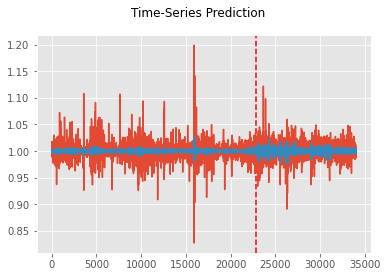

In [ ]:
import matplotlib.pyplot as plt

# The red dashed-line separate the train and test data
linear_model.eval()

# I should predict a series of times instead of always starting with real data
train_predict = linear_model(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = data_predict[:, None]
dataY_plot = dataY_plot[:, None]

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

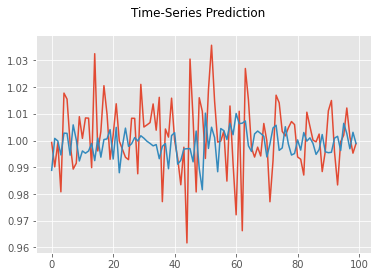

In [ ]:
import matplotlib.pyplot as plt

# The red dashed-line separate the train and test data
# lstm.eval()
linear_model.eval()

# I should predict a series of times instead of always starting with real data
train_predict = linear_model(testX[300:400])

data_predict = train_predict.data.numpy()
dataY_plot = testY[300:400].data.numpy()

data_predict = data_predict[:, None]
dataY_plot = dataY_plot[:, None]

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

## Rollout 
Integrate the model to see if it's capable of learning long range in the future

NOTE: this is broken! Because of extra features :(

In [ ]:
import matplotlib.pyplot as plt

start = 300
iter = 100

linear_model.eval()
data = fetch_data()
input_data = process_data(data)

result = input_data[start:start+SEQ_LENGTH, 1].reshape((SEQ_LENGTH))
for i in range(iter):
  # Grab last 20 entries from result
  model_input = torch.reshape(Variable(torch.Tensor(result[-SEQ_LENGTH:])), (1, SEQ_LENGTH))
  
  # feed through model
  out = linear_model(model_input)

  next_price = out.data.numpy() * result[-1]

  # Add to results
  result = np.append(result, next_price)

# Plot results
plt.plot(result)
plt.plot(input_data[start:start+SEQ_LENGTH+iter])
plt.axvline(x=SEQ_LENGTH - 1, c='r', linestyle='--')
plt.show()



## Model V1 (deprecated)
This is the basic model that runs in a for loop. It's my first attempt.

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

class LinearNet(nn.Module):
  def __init__(self, input_size):
    super().__init__()
    self.linear_1 = nn.Linear(100, 50)
    self.linear_2 = nn.Linear(50, 25)
    self.linear_3 = nn.Linear(25, 5)
    self.linear_4 = nn.Linear(5, 1)
    self.flatten = nn.Flatten(0, 1)
  
  def forward(self, x):
    # normalize the prices by the largest one
    # scalar = torch.max(x)
    # x = torch.div(x, scalar)

    # Network
    x = self.linear_1(x)
    x = self.linear_2(x)
    x = self.linear_3(x)
    x = self.linear_4(x)
    x = self.flatten(x)

    # unnormalize to get the raw price back
    x = torch.mul(x, scalar)
    return x

import wandb
wandb.init()

num_epochs = 5000
learning_rate = 0.01

input_size = 1
hidden_size = 4
num_layers = 1

num_classes = 1

# lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
mlp = LinearNet(seq_length)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

wandb.watch(mlp, log_freq=100)

# Train the model
for epoch in range(num_epochs):
    # outputs = lstm(trainX)
    outputs = mlp(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %4.0d, loss: %1.10f" % (epoch, loss.item()))
      wandb.log({"loss": loss})